In [4]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import json
from pycococreatortools import pycococreatortools

labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'

def load_semantic_json(scene):
    replica_root = '/datasets01/replica/061819/18_scenes'
    habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
    with open(habitat_semantic_json, "r") as f:
        hsd = json.load(f)
    if hsd is None:
        print("Semantic json not found!")
    return hsd

hsd = load_semantic_json('apartment_0')

label_id_dict = {}
new_old_id = {}
idc = 1
for obj_cls in hsd["classes"]:
    if obj_cls["name"] in labels:
        label_id_dict[obj_cls["id"]] = obj_cls["name"]
        new_old_id[obj_cls['id']] = idc
        idc += 1

In [47]:
class Candidate:
    def __init__(self, img_id, l, r, iid):
        self.img_id = img_id
        self.left_prop = l
        self.right_prop = r
        self.instance_id = iid
        
    def __repr__(self):
        return f'[candidate for {self.instance_id}: img_id {self.img_id}, max left prop {self.left_prop}, max right prop {self.right_prop}]\n'

class PickGoodCandidates:
    def __init__(self, img_dir, depth_dir, seg_dir, instance_ids):
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.seg_dir = seg_dir
        self.iids = instance_ids
        self.filtered = False
        self.chosen = set()
        
    def is_open_contour(self, c):
        # check for a bunch of edge points
        # c is of the format num_points * 1 * 2
        edge_points = []
        for x in c:
            if x[0][0] == 0 or x[0][1] == 0 or x[0][0] == 511 or x[0][1] == 511:
                edge_points.append(x)
#         print(len(edge_points))
        if len(edge_points) > 0:
            return True
        return False
    
    def is_iid_in_full_view(self, img_id, iid):
        seg_path = os.path.join(self.seg_dir, "{:05d}.npy".format(img_id))
#         print(f'seg_path {seg_path}')
        annot = np.load(seg_path).astype(np.uint32)
        binary_mask = np.zeros_like(annot)
        
        if iid in np.unique(annot):
            binary_mask = (annot == iid).astype(np.uint32)

        area = binary_mask.sum()
        if area < 1000: # too small
            return False, area
        
        # Check that all masks are within a certain distance from the boundary
        # all pixels [:10,:], [:,:10], [-10:], [:-10] must be 0:
        if binary_mask[:10,:].any() or binary_mask[:,:10].any() or binary_mask[:,-10:].any() or binary_mask[-10:,:].any():
            return False, area
        
        return True, area
        
        
    def sample_uniform_nn2(self, n):
        if n > 1:
            print(f'WARNING: NOT IMPLEMENTED FOR N > 1 YET!')
            return
        frames = []
        for iid in self.iids:
            """
            for each frame that has the instance in view, find the left and right neighborhood of views.
            this is the maxmimal prop length on each side. 
            Pick the frame that has maximal(l+r).
            visualize the entire range. propagate l, r
            """
            print(f'picking {n} candidate for instance {iid} ... ')
            view_arr = {}
            imgs = os.listdir(self.img_dir)
            for img in imgs:
                img_id = int(img.split('.')[0])
                in_view, area = self.is_iid_in_full_view(img_id, iid)
                view_arr[img_id] = (in_view, area)
                
#             print(view_arr)
            # find contiguous blocks
            seq_len = np.zeros(len(imgs))
            for i in range(len(imgs)):
                if view_arr[i][0]:
                    seq_len[i] = 1 + (seq_len[i-1] if i > 0 else 0)
                else:
                    seq_len[i] = 0
                    
            # find index with max value
            candidate = seq_len.argmax()
            
            # now return the max prop length to the left and right of this frame
            l = 0
            d = 1
            while True:
                nxt = candidate - d
                if nxt >= 0 and view_arr[nxt][1] > 0:
                    l += 1
                    d += 1
                else:
                    break
                    
            r = 0
            d = 1
            while True:
                nxt = candidate + d
                if nxt < len(imgs) and view_arr[nxt][1] > 0:
                    r += 1
                    d += 1
                else:
                    break
            
                
            print(f'picked candidate {candidate}, max left prop {l}, max right prop {r}')
            frames.append(Candidate(candidate, l, r, iid))
        return frames
        
    def vis(self, candidate, contours=None):
        
        # visualize left prop
        fig, axs = plt.subplots(1, candidate.left_prop+1, figsize=(2*candidate.left_prop,4))
        l = candidate.img_id-candidate.left_prop
        for x in range(candidate.img_id-candidate.left_prop, candidate.img_id+1):
            img_path = os.path.join(self.img_dir, "{:05d}.jpg".format(x))
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            axs[x-l].imshow(image)
            axs[x-l].set_title("{:05d}.jpg".format(x))
        plt.show()
        
        fig2, axs2 = plt.subplots(1, candidate.right_prop+1, figsize=(2*candidate.right_prop, 4))
        l = candidate.img_id
        for x in range(candidate.img_id, candidate.img_id+candidate.right_prop+1):
            img_path = os.path.join(self.img_dir, "{:05d}.jpg".format(x))
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            if candidate.right_prop == 0:
                axs2.imshow(image)
                axs2.set_title("{:05d}.jpg".format(x))
            else:
                axs2[x-l].imshow(image)
                axs2[x-l].set_title("{:05d}.jpg".format(x))
            
        plt.show()

picking 1 candidate for instance 243 ... 
picked candidate 139, max left prop 32, max right prop 0
picking 1 candidate for instance 404 ... 
picked candidate 28, max left prop 28, max right prop 17
picking 1 candidate for instance 196 ... 
picked candidate 105, max left prop 25, max right prop 1
picking 1 candidate for instance 133 ... 
picked candidate 74, max left prop 11, max right prop 5
picking 1 candidate for instance 170 ... 
picked candidate 136, max left prop 29, max right prop 3
[[candidate for 243: img_id 139, max left prop 32, max right prop 0]
, [candidate for 404: img_id 28, max left prop 28, max right prop 17]
, [candidate for 196: img_id 105, max left prop 25, max right prop 1]
, [candidate for 133: img_id 74, max left prop 11, max right prop 5]
, [candidate for 170: img_id 136, max left prop 29, max right prop 3]
]


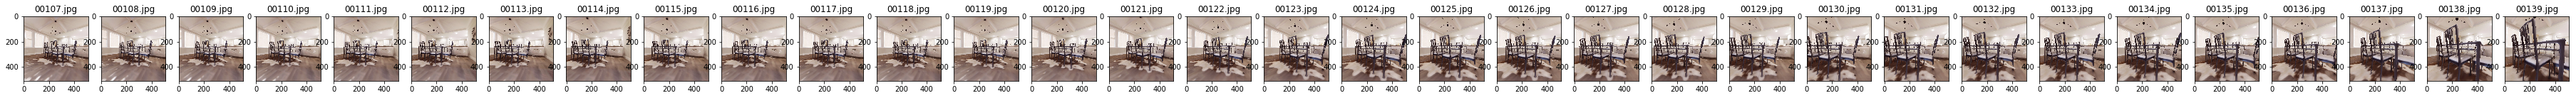

/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/matplotlib/axes/_base.py:1568: RuntimeWarning: divide by zero encountered in double_scalars
  fig_aspect = figH / figW
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

<Figure size 0x288 with 1 Axes>

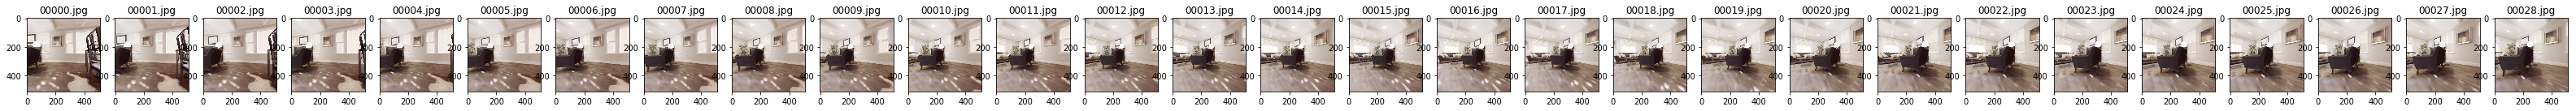

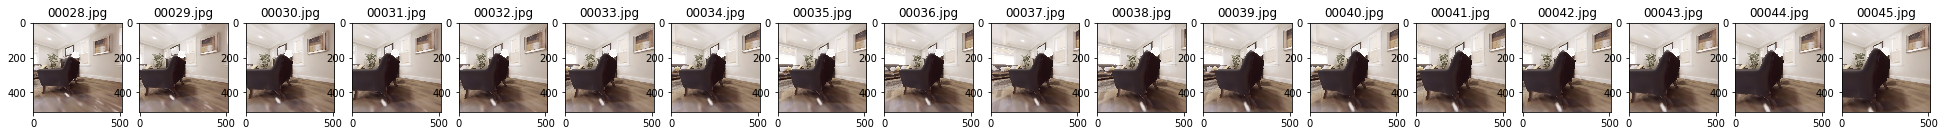

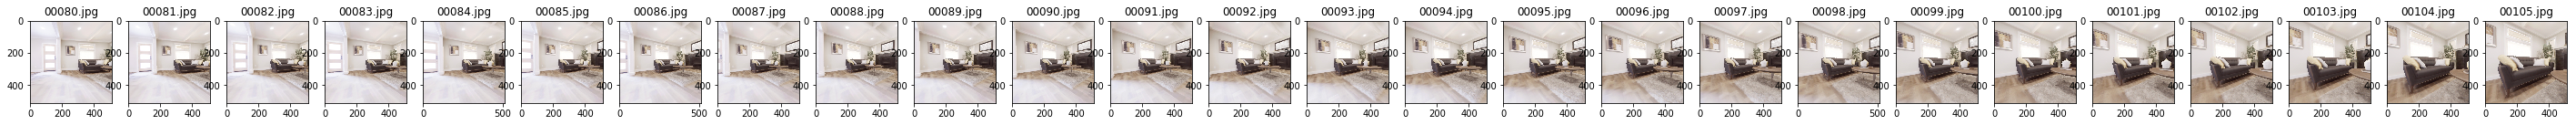

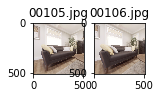

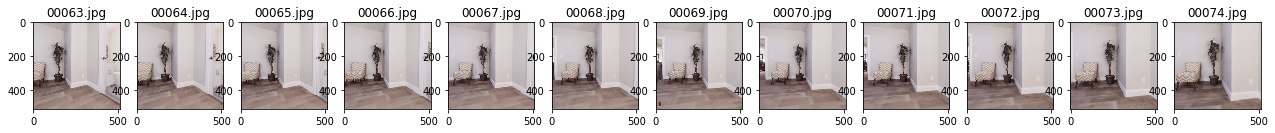

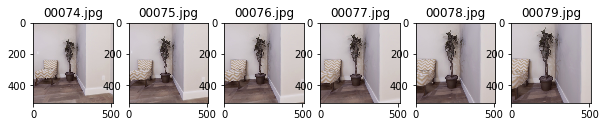

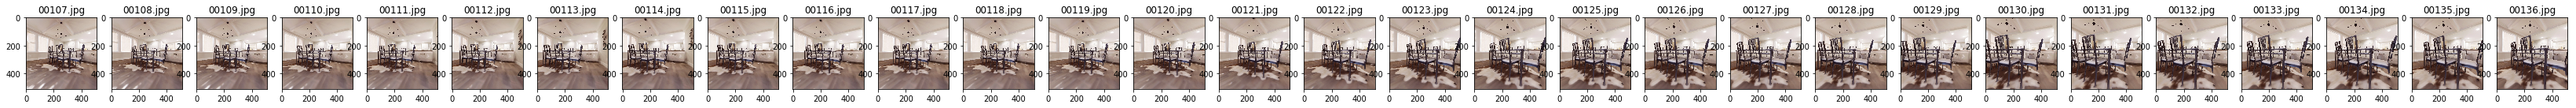

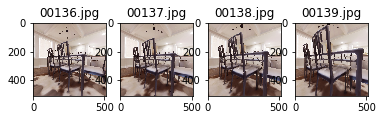

picking 1 candidate for instance 243 ... 
picked candidate 54, max left prop 54, max right prop 17
picking 1 candidate for instance 404 ... 
picked candidate 113, max left prop 41, max right prop 27
picking 1 candidate for instance 196 ... 
picked candidate 132, max left prop 60, max right prop 35
picking 1 candidate for instance 133 ... 
picked candidate 174, max left prop 6, max right prop 10
picking 1 candidate for instance 170 ... 
picked candidate 193, max left prop 8, max right prop 5
[[candidate for 243: img_id 54, max left prop 54, max right prop 17]
, [candidate for 404: img_id 113, max left prop 41, max right prop 27]
, [candidate for 196: img_id 132, max left prop 60, max right prop 35]
, [candidate for 133: img_id 174, max left prop 6, max right prop 10]
, [candidate for 170: img_id 193, max left prop 8, max right prop 5]
]


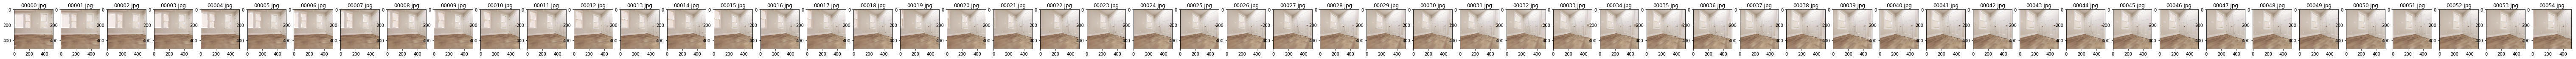

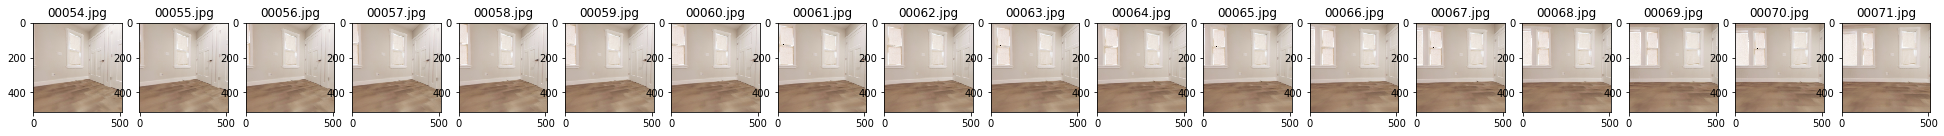

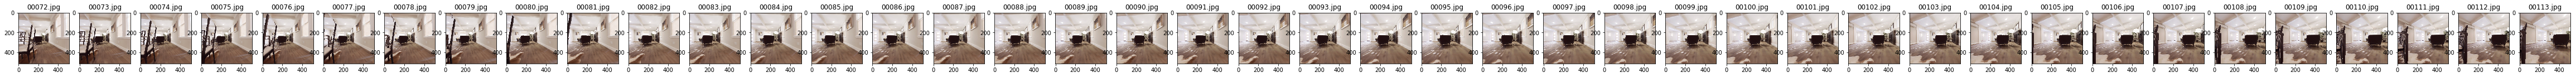

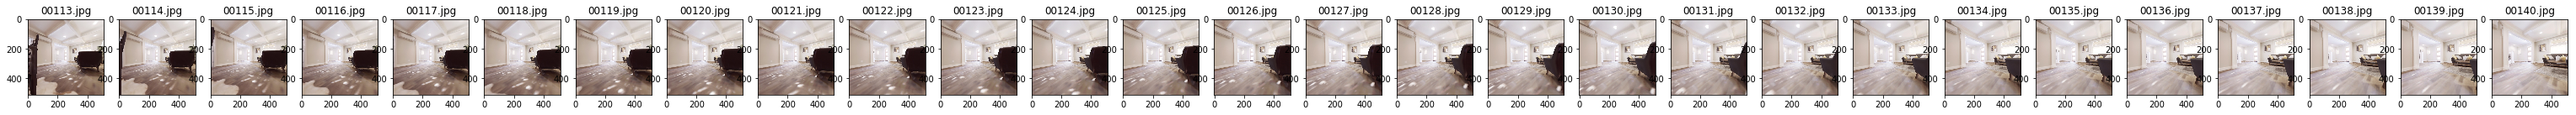

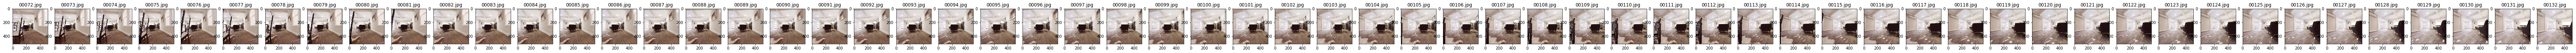

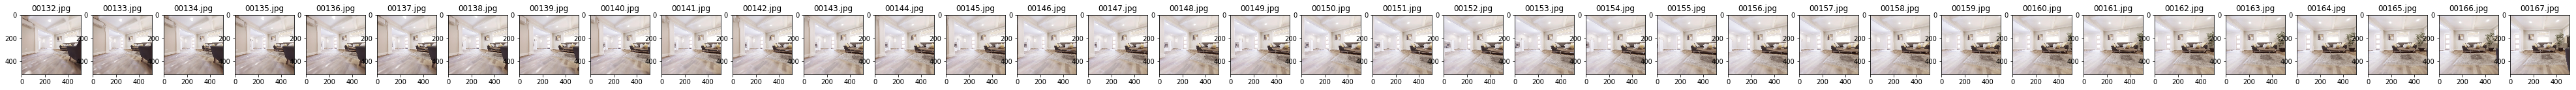

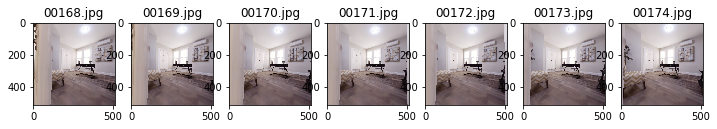

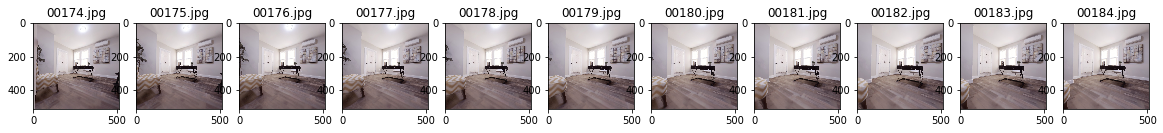

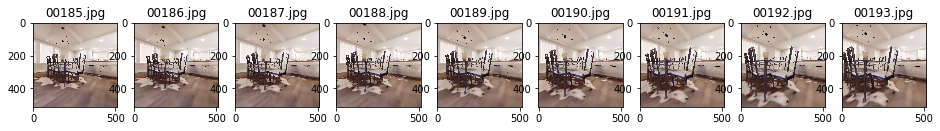

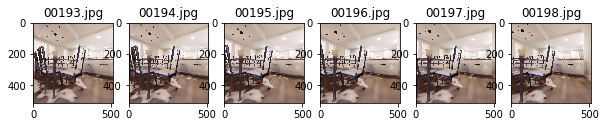

In [50]:
act_data_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection_ids_allinone_auto'
def_data_dir = '/checkpoint/apratik/data/data/apartment_0/default/no_noise/instance_detection_ids_allinone_3'

def get_candidates(data_dir):
    img_dir = os.path.join(data_dir, 'rgb')
    depth_dir = os.path.join(data_dir, 'depth')
    seg_dir = os.path.join(data_dir, 'seg')
    instance_ids = [243,404,196,133,170] #[404,196,172,243,133,129,170]


    s = PickGoodCandidates(img_dir=img_dir, depth_dir=depth_dir, seg_dir=seg_dir, instance_ids=instance_ids)

    for gt in [1]:
    #     xs = s.sample_uniform_nn(gt)
        # pick gt frames for each instance 
        x2 = s.sample_uniform_nn2(gt)
        print(x2)
        for x in x2:
    #         print(x)
            s.vis(x)
        
get_candidates(act_data_dir)
get_candidates(def_data_dir)

In [1]:
gtps = []
for gt in range(5, 15, 5):
    for p in range(0, 30, 5):
        gtps.append((gt,p))

print(len(gtps), gtps)

30 [(5, 0), (5, 5), (5, 10), (5, 15), (5, 20), (5, 25), (10, 0), (10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (15, 0), (15, 5), (15, 10), (15, 15), (15, 20), (15, 25), (20, 0), (20, 5), (20, 10), (20, 15), (20, 20), (20, 25), (25, 0), (25, 5), (25, 10), (25, 15), (25, 20), (25, 25)]


In [ ]:
[(5, 0), (5, 5),b(5, 10), (5, 15), (5, 20), (5, 25), (10, 0), (10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (15, 0), (15, 5), (15, 10), (15, 15), (15, 20), (15, 25), (20, 0), (20, 5), (20, 10), (20, 15), (20, 20), (20, 25), (25, 0), (25, 5), (25, 10), (25, 15), (25, 20), (25, 25)]

In [7]:
gtps = set()
for gt in range(5, 15, 5):
    for p in range(0, 30, 5):
        gtps.add((gt,p))

for gt in range(5, 30, 5):
    for p in range(0,15,5):
        gtps.add((gt,p))

gtps = sorted(list(gtps))
print(len(gtps), gtps)

21 [(5, 0), (5, 5), (5, 10), (5, 15), (5, 20), (5, 25), (10, 0), (10, 5), (10, 10), (10, 15), (10, 20), (10, 25), (15, 0), (15, 5), (15, 10), (20, 0), (20, 5), (20, 10), (25, 0), (25, 5), (25, 10)]


In [6]:
for gt, p in gtps:
    print(gt, p)

25 5
10 15
15 5
5 5
15 0
20 0
5 25
25 0
5 0
10 0
15 10
20 10
5 15
20 5
25 10
10 5
5 10
10 10
10 25
5 20
10 20
